# **Sentinel-3 SLSTR Level-1 Data Processing(TOA Reflectance)**

## **Introduction**



This notebook contains processing steps of SLSTR Level-1 to achieve the following tasks:

1.   **Understand** the data and file structure.
2.   **Load** Sentinel-3 SLSTR TOA reflectance data.
3.   **Apply preprocessing** Steps: Scaling, Cloud masking.
4.   **Calculate NDVI**.
5.   **Visualize** and **save** it as netCDF.

## **Description**

The SLSTR Level-1 data has nine spectral bands that detect tops of atmosphere(TOA) radiation in the VNIR/SWIR/TIR regions. It provides observations from two different views:

1.  **Nadir View:** 1400 km across track
2.   **Oblique View:** 740 km across track

The radiance in **vis and near-infrared** bands are directly measured by sensors and must be converted to **reflectance**.

The data are available for different tracks:

1.  **Forward track(f)**
2.  **Along track(a)**
3.  **Intermediate(i)**
4.  **Across(b)**

This notebook processes the bands**(s1-s6)** across all the above mentioned **tracks** and **views**.



**References:**


*   [Sentinel-3 SLSTR Level-1 Data Guide](https://user.eumetsat.int/resources/user-guides/sentinel-3-slstr-level-1-data-guide)
*   [Sentinel-3 Product Data Format Specification](https://sentiwiki.copernicus.eu/__attachments/1672112/S3IPF.PDS.005.1%20-%20Sentinel%203%20Product%20Data%20Format%20Specification%20SLSTR%20Level%201%202021%20-%202.10.pdf?inst-v=f9683405-accc-4a3f-a58f-01c9c5213fb1).

# Install required libraries

In [1]:
# !pip install --upgrade --force-reinstall netCDF4 h5netcdf h5py xarray cftime gdown

In [2]:
# Uncomment to download the data; once downloaded, comment it out to avoid re-downloading.
# !rm -rf extracted_files/

In [3]:
!rm -rf reflectances/

In [4]:
import os
import glob
import shutil
import zipfile
import numpy as np
import gdown
import psutil
import xarray as xr
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from pprint import pprint
from google.colab import drive

import dask
from dask import delayed
from dask.distributed import Client

##### Configurations

In [5]:
folder_id = "1boXL79ZD-efssr-UtgmMiTc3OtHQOFUH"
data_dir = "/content/extracted_files"
output_dir = "/content/output"

# Download the data and unzip the files

In [6]:
def unzip(filepath, dest):
  if not os.path.exists(dest):
      with zipfile.ZipFile(filepath, 'r') as zip_ref:
          zip_ref.extractall(dest)

In [7]:
if not os.path.exists(data_dir) or not os.listdir(data_dir):
    print("Folder does not exist or is empty. Downloading files...")
    os.makedirs(data_dir, exist_ok=True)
    !gdown --folder https://drive.google.com/drive/folders/{folder_id} -O {data_dir}
else:
    print("Folder already exists. Skipping download.")

Folder already exists. Skipping download.


In [8]:
files = [f for f in os.listdir(data_dir) if f.endswith('.zip')]
print(f"Files available to process")
pprint(files)

for filename in files:
  print(f"unzipping file: {filename}")
  filepath = os.path.join(data_dir, filename)
  basename , _ = os.path.splitext(filename)
  destdir = os.path.join(data_dir, basename)
  unzip(filepath, destdir)

Files available to process
['S3A_SL_1_RBT____20190621T104216_20190621T104516_20210113T083124_0179_046_108_2340_LR1_R_NT_004.SEN3.zip',
 'S3A_SL_1_RBT____20190621T103916_20190621T104216_20210113T083124_0180_046_108_2160_LR1_R_NT_004.SEN3.zip']
unzipping file: S3A_SL_1_RBT____20190621T104216_20190621T104516_20210113T083124_0179_046_108_2340_LR1_R_NT_004.SEN3.zip
unzipping file: S3A_SL_1_RBT____20190621T103916_20190621T104216_20210113T083124_0180_046_108_2160_LR1_R_NT_004.SEN3.zip


In [9]:
folders_to_process = [file.replace(".zip", "") for file in files]
folders_to_process

['S3A_SL_1_RBT____20190621T104216_20190621T104516_20210113T083124_0179_046_108_2340_LR1_R_NT_004.SEN3',
 'S3A_SL_1_RBT____20190621T103916_20190621T104216_20210113T083124_0180_046_108_2160_LR1_R_NT_004.SEN3']

# Load the metadata

In [10]:
file = "S3A_SL_1_RBT____20190621T103916_20190621T104216_20210113T083124_0180_046_108_2160_LR1_R_NT_004.SEN3"
folderpath = os.path.join(data_dir, file)
files_folderpath =  os.path.join(folderpath, file)

def parse_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    metadata = {}
    for elem in root.iter():
        if elem.text and elem.text.strip():
            metadata[elem.tag] = elem.text.strip()
    return metadata

def extract_bounding_box(eop_metadata):
    pos_list_key = '{http://www.opengis.net/gml/3.2}posList'
    if pos_list_key in eop_metadata:
        pos_list = list(map(float, eop_metadata[pos_list_key].split()))
        if len(pos_list) >= 8:
            bounding_box = {
                "min_lon": min(pos_list[0::2]),
                "max_lon": max(pos_list[0::2]),
                "min_lat": min(pos_list[1::2]),
                "max_lat": max(pos_list[1::2])
            }
            return bounding_box
    return None

folderpath = os.path.join(data_dir, file)
manifest_file = os.path.join(folderpath, "manifest.xml")
eop_file = os.path.join(folderpath, "EOPMetadata.xml")

manifest_metadata = parse_xml(manifest_file)
eop_metadata = parse_xml(eop_file)
pprint(eop_metadata)

{'{http://www.eumetsat.int/eop/1.0}cycleNumber': '46',
 '{http://www.eumetsat.int/eop/1.0}granuleType': 'DP',
 '{http://www.eumetsat.int/eop/1.0}processingLevel': '01',
 '{http://www.eumetsat.int/eop/1.0}relOrbitStart': '108',
 '{http://www.opengis.net/eop/2.1}acquisitionStation': 'CGS',
 '{http://www.opengis.net/eop/2.1}acquisitionSubType': 'Operational',
 '{http://www.opengis.net/eop/2.1}acquisitionType': 'NOMINAL',
 '{http://www.opengis.net/eop/2.1}identifier': 'S3A_SL_1_RBT____20190621T103916_20190621T104216_20210113T083124_0180_046_108_2160_LR1_R_NT_004.SEN3',
 '{http://www.opengis.net/eop/2.1}nativeProductFormat': 'Sentinel-SAFE',
 '{http://www.opengis.net/eop/2.1}orbitNumber': '17406',
 '{http://www.opengis.net/eop/2.1}orbitType': 'LEO',
 '{http://www.opengis.net/eop/2.1}parentIdentifier': 'EO:EUM:DAT:0615',
 '{http://www.opengis.net/eop/2.1}processingCenter': 'EUM',
 '{http://www.opengis.net/eop/2.1}processingDate': '2021-01-13T08:31:24Z',
 '{http://www.opengis.net/eop/2.1}proc

In the following step we load the data and, convert the radiance to TOA reflectance

# **Radiance to TOA reflectance**

Converting radiance to TOA reflectance removes cosine effect caused by variations in solar zenith angles due to time difference.

1. **Formula for Reflectance Calculation**

  The reflectance is calculated using the following formula:

  $$
  \text{Reflectance} = \pi \times \frac{\text{ToA Radiance}}{\text{Solar Irradiance} \times \cos(\text{Solar Zenith Angle})}
  $$

  where:

  - **ToA Radiance**: The radiance values from the SLSTR bands.
  - **Solar Irradiance**: Provided in the ‘quality’ dataset for each channel.
  - **Solar Zenith Angle**: Available in the ‘geometry’ dataset.
  - $\pi$ **(Pi)**: A normalization factor.

2. The following values required for TOA reflectance are read from respective files:
  *  **irradiance**: `S<n>_quality_<vv>.nc`.
  *  **solar zenith angle**:  `geometry_tn`.
  *  **scaling factor(radiance)**:  [Sentinel-3 Product Data Format Specification](https://sentiwiki.copernicus.eu/__attachments/1672112/S3IPF.PDS.005.1%20-%20Sentinel%203%20Product%20Data%20Format%20Specification%20SLSTR%20Level%201%202021%20-%202.10.pdf?inst-v=f9683405-accc-4a3f-a58f-01c9c5213fb1)(Page 65, 7.1.1.4.1).


  **References**:
* [Copernicus Sentinel-3 SLSTR Land User Handbook](https://sentinel.esa.int/documents/247904/4598082/Sentinel-3-SLSTR-Land-Handbook.pdf).(Page 55, 8.2.9)
* [Sentinel-3 Product Data Format Specification](https://sentiwiki.copernicus.eu/__attachments/1672112/S3IPF.PDS.005.1%20-%20Sentinel%203%20Product%20Data%20Format%20Specification%20SLSTR%20Level%201%202021%20-%202.10.pdf?inst-v=f9683405-accc-4a3f-a58f-01c9c5213fb1)(Page 65, 7.1.1.4.1).




In [11]:
def save_to_netcdf(toa_reflectance, output_filepath):
    """Save the TOA reflectance as a NetCDF file."""

    toa_reflectance_da = xr.DataArray(toa_reflectance, dims=["rows", "columns"])
    ds = xr.Dataset({
        "toa_reflectance": toa_reflectance_da
    })
    ds.to_netcdf(output_filepath)
    # print(f"File saved successfully at {output_filepath}")

def plot_radiance_and_reflectance(toa_radiance, toa_reflectance):
    """
    Plots Radiance and TOA Reflectance side by side.

    Parameters:
    - toa_radiance: 2D array of radiance values (W/m²·sr·µm)
    - toa_reflectance: 2D array of TOA reflectance values
    """

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    im_radiance = axes[0].imshow(toa_radiance, cmap='viridis', aspect='auto')
    axes[0].set_title("Radiance")
    axes[0].set_xlabel("Columns")
    axes[0].set_ylabel("Rows")
    plt.colorbar(im_radiance, ax=axes[0], label="Radiance (W/m²·sr·µm)")

    im_reflectance = axes[1].imshow(toa_reflectance, cmap='viridis', aspect='auto')
    axes[1].set_title("TOA Reflectance")
    axes[1].set_xlabel("Columns")
    axes[1].set_ylabel("Rows")
    plt.colorbar(im_reflectance, ax=axes[1], label="TOA Reflectance")

    plt.tight_layout()
    plt.show()


def _get_solarzenith(folder):
  """ Read the solar zenith value from geometry file """
  geometry_filepath = os.path.join(folder, "geometry_tn.nc")
  ds = xr.open_dataset(geometry_filepath)
  solar_zenith_tn = ds["solar_zenith_tn"]

  # Fix NaN pixel values in solar_zenith by replacing them with the mean value
  # The NaN values could be causing issues in further processing, so we handle them here
  mean_value = solar_zenith_tn.mean().values
  solar_zenith_tn = solar_zenith_tn.fillna(mean_value)

  ds.close()

  return solar_zenith_tn

def _get_flags(folder, vv):
  """ Read the cloud data from flags file """
  flag_filepath = os.path.join(folder, f"flags_{vv}.nc")
  ds = xr.open_dataset(flag_filepath)
  cloud_variable = f"cloud_{vv}"
  ds.close()
  return ds[cloud_variable]

def _get_irradiance(folder, filename, detector=2):
  """ Read irradiance value from respective quality filepath """
  quality_filepath = os.path.join(folder, filename)
  ds = xr.open_dataset(quality_filepath)

  radiance_variable = [var for var in ds.variables if '_solar_irradiance_' in var][0]
  solar_irradiance = ds[radiance_variable].values
  return solar_irradiance[detector]

def _convert_toa_radiance_to_reflectance(toa_radiance, solar_irradiance, solar_zenith):
  """ Convert toa radiance to reflectance """
  solar_zenith_cos = np.cos(np.deg2rad(solar_zenith))
  reflectance =  np.pi * (toa_radiance / (solar_irradiance * solar_zenith_cos))
  # print(f"Min Reflectance: {np.min(reflectance)}")
  # print(f"Max Reflectance: {np.max(reflectance)}")
  return reflectance

def _get_radiance(ds):
  """ Read radiance values """
  radiance_variable = [var for var in ds.variables if '_radiance_' in var][0]
  radiance = ds[radiance_variable]
  return radiance

def _downsample_radiance(data, rows, cols):
  """ Downsample data values """
  return data.interp(
        rows=np.linspace(0, data.sizes['rows'], rows),
        columns=np.linspace(0, data.sizes['columns'], cols),
        method="linear"
      )

# scale value is referenced from the SLSTR level 1 documentation
def _scale_radiance(toa_radiance, scale_factor = 0.01, offset = 0):
    """ Apply scaling factor to the TOA radiance """
    return toa_radiance * scale_factor + offset

In [12]:
!rm -rf /content/output/reflectances/

In [13]:
def _process_band_quality_pair(band_file, quality_file, files_folderpath, reflectances_results_dir, folder):
    band_ds = xr.open_dataset(band_file)

    toa_radiance = _get_radiance(band_ds)

    solar_zenith_tn = _get_solarzenith(files_folderpath)
    solar_irradiance = _get_irradiance(files_folderpath, quality_file)
    toa_radiance = _scale_radiance(toa_radiance)

    print(band_file)
    filename = band_file.split("/")[-1]
    basename = filename.split(".")[0]
    vv = basename.split("_")[2]
    cloud_flag = _get_flags(files_folderpath, vv)

    rows, cols = solar_zenith_tn.sizes['rows'], solar_zenith_tn.sizes['columns']

    # Downsample the toa_radiance to match the dimensions
    toa_radiance_downsampled = _downsample_radiance(toa_radiance, rows, cols)
    flags_downsampled = _downsample_radiance(cloud_flag, rows, cols)
    toa_reflectance = _convert_toa_radiance_to_reflectance(toa_radiance_downsampled, solar_irradiance, solar_zenith_tn)
    scaled_reflectance = toa_reflectance / toa_reflectance.max()

    # Save the files (delayed so that the computation happens in parallel)
    output_folder = os.path.join(reflectances_results_dir, folder)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    output_filepath = os.path.join(output_folder, os.path.basename(band_file).replace('radiance', 'reflectance'))

    save_to_netcdf(scaled_reflectance, output_filepath)

    print(f"TOA Reflectance for {os.path.basename(band_file)} saved successfully.")

def _process_reflectance(folder, data_dir, reflectances_results_dir, radiance_file_pattern, quality_file_pattern):
    print(f"\nProcessing folder: {folder}")
    files_folderpath = os.path.join(data_dir, folder, folder)

    tasks = []
    for radiance_pattern, quality_pattern in zip(radiance_file_pattern, quality_file_pattern):
        print(f"Processing radiance_pattern: {radiance_pattern}")

        band_files = glob.glob(os.path.join(files_folderpath, radiance_pattern))
        quality_files = glob.glob(os.path.join(files_folderpath, quality_pattern))

        # Parallelize the processing of band_file and quality_file pair
        for band_file, quality_file in zip(band_files, quality_files):
            basefilename = os.path.basename(band_file)
            print(f"\nCalculating TOA reflectance for band_file: {basefilename}")

            # Delayed task to process each band_file and quality_file pair
            tasks.append(delayed(_process_band_quality_pair)(band_file, quality_file, files_folderpath, reflectances_results_dir, folder))

    dask.compute(*tasks)

# Parallel processing of reflectance for each data imagery
def process_folders_parallel(folders_to_process, data_dir, reflectances_results_dir, radiance_file_pattern, quality_file_pattern):
    tasks = []

    for folder in folders_to_process:
        tasks.append(delayed(_process_reflectance)(folder, data_dir, reflectances_results_dir, radiance_file_pattern, quality_file_pattern))

    dask.compute(*tasks)

# Configure client for parallel processing

In [14]:
# Setting up Dask Client
cpu_cores = psutil.cpu_count(logical=False)
total_memory_gb = psutil.virtual_memory().total / (1024 ** 3)

n_workers = cpu_cores
memory_per_worker_gb = total_memory_gb * 0.2
memory_limit = f'{memory_per_worker_gb:.1f}GB'
threads_per_worker = 2

client = Client(n_workers=n_workers, threads_per_worker=threads_per_worker, memory_limit=memory_limit)
print(f"Client created with {n_workers} workers, {threads_per_worker} threads per worker, and {memory_limit} memory limit.")

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.diskutils:Found stale lock file and directory '/tmp/dask-scratch-space/scheduler-q2xj3z_o', purging
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:40957
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43853'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:36391 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:36391
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:52778
INFO:distributed.scheduler:Receive client connection: Client-81b5a05a-028f-11f0-94f3-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:52782


Client created with 1 workers, 2 threads per worker, and 2.5GB memory limit.


In [15]:
# process TOA reflectance
radiance_file_pattern = ["S*_radiance_an.nc", "S*_radiance_ao.nc"]
quality_file_pattern = ["S*_quality_an.nc", "S*_quality_ao.nc"]

reflectances_results_dir = os.path.join(output_dir, "reflectances")
os.makedirs(reflectances_results_dir, exist_ok=True)

process_folders_parallel(folders_to_process, data_dir, reflectances_results_dir, radiance_file_pattern, quality_file_pattern)

INFO:distributed.scheduler:Receive client connection: Client-worker-842f4b1f-028f-11f0-9556-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:52800


# **Cloud Mask, Level 1**
Basic Level-1 cloud mask, Bayes cloud

* **flag_masks:** Masks for each flag bit
* **flag_meanings:** Text descriptions for each flag bit

**References:**
  *  [Sentinel-3 Core PDGS Instrument Processing Facility (IPF) Implementation](https://user.eumetsat.int/s3/eup-strapi-media/S3_IPF_PDS_005_1_i2r9_Product_Data_Format_Specification_SLSTR_Level_1_c91250e482.pdf)


In [16]:
#TODO

# **NDVI Computation**
In this step, we compute Normalized Difference Vegetation Index (NDVI). It is a index that is useful to assess vegetation health by analyzing electromagnetic radiation by plant in different wavelengths(Red and NIR). The change in NDVI can provides us the insights regarding problems in vegetation. Not only that we can also use it to identify grassland, denseforest etc.

 According to the SLSTR documentation, the S2 and S3 are Red and NIR which we can use to calculate NDVI index. The value ranges from -1 to 1 and the values represent following info:

*  Healthy (> 0.6)
*  Moderate (0.2 - 0.6)
*  Poor (< 0.2)



**NDVI Formula**

The formula to calculate NDVI is:
$$
NDVI = \frac{(NIR - Red)}{(NIR + Red)}
$$

where:
- \( NIR \) = Near-Infrared Band (e.g., Sentinel-3 S3)
- \( Red \) = Red Band (e.g., Sentinel-3 S2)

The files are save in output/ndvi folder in both **netCDF and png format.**

**References:**
  * [Sentinel-3 SLSTR level 1 data guide](https://user.eumetsat.int/resources/user-guides/sentinel-3-slstr-level-1-data-guide).(SLSTR instrument specifics)



In [17]:
!rm -rf /content/output/ndvi/

In [18]:
def save_ndvi_as_netcdf(ndvi, file_path):
    """Save NDVI as a NetCDF file."""
    ndvi_da = xr.DataArray(ndvi, dims=["rows", "columns"], name="ndvi")
    print(f"saving netcdf file: {file_path}")
    ndvi_da.to_netcdf(file_path)

@delayed
def get_toa_reflectance(reflectance_file):
    """Fetch TOA reflectance from the given NetCDF file."""
    ds = xr.open_dataset(reflectance_file)
    toa_reflectance = ds['toa_reflectance']
    ds.close()
    return toa_reflectance

def plot_and_save_ndvi(ndvi, png_filepath=None, save=True):
    """Plot the NDVI map with a colorbar indicating vegetation health."""
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1, aspect='auto', interpolation="nearest")
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("NDVI", fontsize=10)
    ax.set_title("NDVI - Vegetation Health", fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.text(0.5, 0, "Healthy (>0.6)   |   Moderate (0.2 - 0.6)   |   Novegetation (<0.2)",
             ha='center', fontsize=11, fontweight='bold', color="#333333")
    if save:
      plt.savefig(png_filepath, bbox_inches='tight', dpi=300)
    else:
      plt.show()

def check_min_max(red_band):
    """Check and print the min and max values of the red_band."""
    min_value = np.min(red_band)
    max_value = np.max(red_band)
    print(f"Red Band - Min Value: {min_value}, Max Value: {max_value}")
    return min_value, max_value

@delayed
def process_ndvi(folder, view, reflectances_results_dir, ndvi_results_dir):
    reflectance_files = os.path.join(reflectances_results_dir, folder)

    red_filepath = os.path.join(reflectance_files, f"S2_reflectance_{view}.nc")
    nir_filepath = os.path.join(reflectance_files, f"S3_reflectance_{view}.nc")

    red_band_task = get_toa_reflectance(red_filepath)
    nir_band_task = get_toa_reflectance(nir_filepath)

    # process it parallely, delayed fetching
    red_band, nir_band = dask.compute(red_band_task, nir_band_task)

    check_min_max(red_band)
    check_min_max(nir_band)

    ndvi = (nir_band - red_band) / (nir_band + red_band)
    ndvi = np.clip(ndvi, -1, 1)

    output_folder = os.path.join(ndvi_results_dir, folder)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    output_filepath = os.path.join(output_folder, f"s3_ndvi.nc")
    save_ndvi_as_netcdf(ndvi, output_filepath)

    # png_filepath =  os.path.join(output_folder, f"s3_ndvi.png")
    # plot_and_save_ndvi(ndvi, png_filepath)

def process_ndvi_computations(folders_to_process, views, reflectances_results_dir, ndvi_results_dir):
    tasks = []

    # Parallelize the ndvi calculation for each file
    for folder in folders_to_process:
        for view in views:
            tasks.append(delayed(process_ndvi)(folder, view, reflectances_results_dir, ndvi_results_dir))

    results = dask.compute(*tasks)
    return results


views = ['an', 'ao']
ndvi_results_dir = os.path.join(output_dir, "ndvi")
os.makedirs(reflectances_results_dir, exist_ok=True)
process_ndvi_computations(folders_to_process, views, reflectances_results_dir, ndvi_results_dir)

(None, None, None, None)

# **Visualization**

The files are read from the output/ndvi folder from respective imagery folder and visualized.  The NDVI visualization indices values ranges from -1 to 1 and the each value represents following info:

* Healthy (> 0.6)
* Moderate (0.2 - 0.6)
* Poor Health (0 - 0.2)
* No vegetation (< 0)

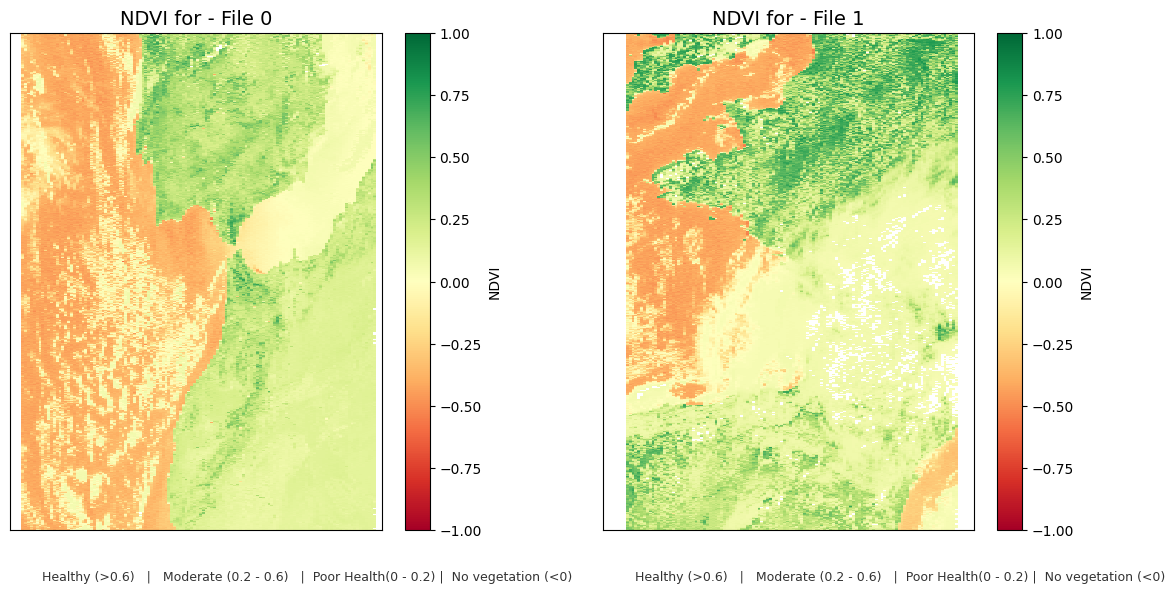

In [19]:
def display_ndvi_2x2(ndvi, ax=None, index=0):
    """Plot the NDVI map with a colorbar indicating vegetation health."""
    im = ax.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1, aspect='auto', interpolation="nearest")
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("NDVI", fontsize=10)
    ax.set_title(f"NDVI for - File {index}", fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.8, -0.1, "Healthy (>0.6)   |   Moderate (0.2 - 0.6)   |  Poor Health(0 - 0.2) |  No vegetation (<0)",
            ha='center', fontsize=9, color="#333333", transform=ax.transAxes)
    return

ndvi_results_dir = os.path.join(output_dir, "ndvi")
n_cols = 2
n_rows = len(folders_to_process) // n_cols + (len(folders_to_process) % n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6))
axes = axes.flatten()

for i, folder in enumerate(folders_to_process):
    folder_path = os.path.join(ndvi_results_dir, folder)
    filepath = os.path.join(folder_path, "s3_ndvi.nc")
    ds = xr.open_dataset(filepath)
    ndvi = ds['ndvi'].values
    ax = axes[i]
    display_ndvi_2x2(ndvi, ax=ax, index=i)
    ds.close()

plt.tight_layout()
plt.show()